<a href="https://colab.research.google.com/github/Dany503/CFP_2019/blob/master/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Importamos la librerías y cargamos los datos de nuestro drive

In [0]:
import pandas
import numpy


products = pandas.read_csv('/content/drive/My Drive/amazon_2.csv', low_memory=False, sep=',')
products = products.fillna({'name':''})  # fill in N/A's in the review column
products = products.fillna({'review':''})  # fill in N/A's in the review column
print(products.dtypes)
products.review=products.review.astype(str)

name      object
review    object
rating     int64
dtype: object


Operaciones:
* Eliminar signos de puntuación
* Eliminar reviews neutrales (rating 3).
* Definir reviews con rating >=4 como positivas (+1) y reviews con rating <= 2 negativas (-1)


In [0]:
def remove_punctuation(text):
    import string
    replace_punctuation=str.maketrans(string.punctuation, ' '*len(string.punctuation))
    return text.translate(replace_punctuation) 

products['review_clean'] = products['review'].apply(remove_punctuation)
products['review_clean'] = products['review_clean'].map(lambda x: x.lower())

# Eliminar reviews neutrales
products = products[products['rating'] != 3]
# Sentimiento positivo +1 y sentimiento negativo ‐1
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

Dividimos los datos en train y test

In [0]:
numpy.random.seed(1) 
msk = numpy.random.rand(len(products)) < 0.8
train_data = products[msk]
test_data = products[~msk]
print (len(train_data))
print (len(test_data))    

42497
10575


Entrenamiento de un clasificador logístico

significant_words = ['love', 'great', 'easy', 'old', 'little', 'perfect', 'loves', 
      'well', 'able', 'car', 'broke', 'less', 'even', 'waste', 'disappointed', 
       'work', 'product', 'money', 'would', 'return']

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# Representación de documentos como bolsa de palabras
#vectorizer = CountVectorizer(vocabulary=significant_words) # limit to 20 words

# Representacion de documentos de training a partir de la bolsa de palabras
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Representacion de documentos de test a partir de la bolsa de palabras
test_matrix = vectorizer.transform(test_data['review_clean'])

# Entrenamiento de clasificador logístico
from sklearn import linear_model
model = linear_model.LogisticRegression()
model.fit(train_matrix, train_data['sentiment'])


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Métricas del clasificador

In [0]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'], y_pred=model.predict(test_matrix))
print ("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.8948463356973996


Baseline: Predicción de la clase mayoritaria

In [0]:
baseline = len(test_data[test_data['sentiment'] == 1])/float(len(test_data))
print ("Baseline accuracy (majority class classifier): %s" % baseline)


Baseline accuracy (majority class classifier): 0.5015602836879433


Matriz de confunsión

In [0]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'],y_pred=model.predict(test_matrix),labels=model.classes_) # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('‐‐‐‐‐‐‐‐‐‐‐‐‐‐+‐‐‐‐‐‐‐‐‐‐‐‐‐‐‐‐‐+‐‐‐‐‐‐‐')
# Imprimir matriz de confusión
for i, target_label in enumerate(model.classes_):
 for j, predicted_label in enumerate(model.classes_):
  print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))


 target_label | predicted_label | count 
‐‐‐‐‐‐‐‐‐‐‐‐‐‐+‐‐‐‐‐‐‐‐‐‐‐‐‐‐‐‐‐+‐‐‐‐‐‐‐
     -1       |       -1        |  4718
     -1       |        1        |   553
      1       |       -1        |   559
      1       |        1        |  4745


Otras métricas

In [0]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'],y_pred=model.predict(test_matrix))
print ("Precision de datos de test: %s" % precision)


from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'],y_pred=model.predict(test_matrix))
print ("Recall de datos de test: %s" % recall)

Precision de datos de test: 0.8956209890524727
Recall de datos de test: 0.8946078431372549


Precision recall tradeoff

In [0]:
# Varying the threshold

def apply_threshold(probabilities, threshold):
### YOUR CODE GOES HERE
# +1 if >= threshold and ‐1 otherwise.
  return [1 if x >= threshold else -1 for x in probabilities]

probabilities = model.predict_proba(test_matrix)[:,1]
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)

print ("Number of positive predicted reviews (threshold = 0.5): %s" % \
(sum([x for x in predictions_with_default_threshold if x == 1])))

print ("Number of positive predicted reviews (threshold = 0.9): %s" % \
(sum([x for x in predictions_with_high_threshold if x == 1])))


precision_with_default_threshold = precision_score(y_true=test_data['sentiment'],y_pred=predictions_with_default_threshold)
recall_with_default_threshold = recall_score(y_true=test_data['sentiment'],y_pred=predictions_with_default_threshold)
precision_with_high_threshold = precision_score(y_true=test_data['sentiment'],y_pred=predictions_with_high_threshold)
recall_with_high_threshold = recall_score(y_true=test_data['sentiment'],y_pred=predictions_with_high_threshold)

print ("Precision (threshold = 0.5): %s" % precision_with_default_threshold)
print ("Recall (threshold = 0.5) : %s" % recall_with_default_threshold)

print ("Precision (threshold = 0.9): %s" % precision_with_high_threshold)
print ("Recall (threshold = 0.9) : %s" % recall_with_high_threshold)

Number of positive predicted reviews (threshold = 0.5): 5298
Number of positive predicted reviews (threshold = 0.9): 3964
Precision (threshold = 0.5): 0.8956209890524727
Recall (threshold = 0.5) : 0.8946078431372549
Precision (threshold = 0.9): 0.9548435923309788
Recall (threshold = 0.9) : 0.7136123680241327


Curva presición y recall

Metrics Threshold 0.5 Precision 0.8956209890524727 Recall 0.8946078431372549
Metrics Threshold 0.5050504949494949 Precision 0.8986834573554665 Recall 0.8880090497737556
Metrics Threshold 0.5101009898989899 Precision 0.8990632766201491 Recall 0.8866892911010558
Metrics Threshold 0.5151514848484848 Precision 0.9001150306748467 Recall 0.8851809954751131
Metrics Threshold 0.5202019797979798 Precision 0.9008645533141211 Recall 0.8840497737556561
Metrics Threshold 0.5252524747474747 Precision 0.9016172506738545 Recall 0.8829185520361991
Metrics Threshold 0.5303029696969697 Precision 0.9026651216685979 Recall 0.8812217194570136
Metrics Threshold 0.5353534646464646 Precision 0.9040247678018576 Recall 0.8808446455505279
Metrics Threshold 0.5404039595959595 Precision 0.9051590380139644 Recall 0.8799019607843137
Metrics Threshold 0.5454544545454545 Precision 0.9054552514074937 Recall 0.8793363499245852
Metrics Threshold 0.5505049494949494 Precision 0.9059945504087193 Recall 0.8776395173453997
Met

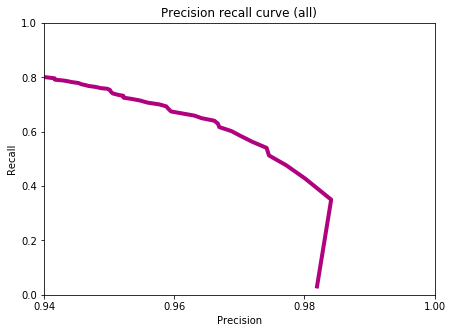

In [0]:
threshold_values = numpy.linspace(0.5, 0.999999, num=100)
precision_all = []
recall_all = []


for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    precision = precision_score(y_true=test_data['sentiment'],y_pred=predictions)
    recall = recall_score(y_true=test_data['sentiment'],y_pred=predictions)
    print ('Metrics Threshold %s Precision %s Recall %s' % (threshold, precision, recall))  
    precision_all.append(precision)
    recall_all.append(recall)


import matplotlib.pyplot as plt


def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.xlim(0.94, 1.0)   #0.78
    plt.ylim(0.0, 1.0)
    plt.rcParams.update({'font.size': 16})

plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')